Transfer learning: Fine Tunning

In [ ]:
!pip install torchmetrics

In [ ]:
from torchvision import models
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.datasets import FashionMNIST
from torchmetrics import Accuracy
import matplotlib.pyplot as plt


# Load a pretrained ResNet
model = models.resnet50(weights='IMAGENET1K_V2')

# Replace final layer for CIFAR-10
model.fc = nn.Linear(model.fc.in_features, 10)

# Unfreeze last two layers for fine-tuning
for name, param in model.named_parameters():
    if "layer3" in name or "layer4" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False  # freeze earlier layers



In [ ]:
classes = [
    "airplane", "automobile", "bird", "cat",
    "deer", "dog", "frog", "horse", "ship",
    "truck"
]


transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225]) ])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]) ])

train_dataset = datasets.CIFAR10(
    root='./data',
    train=True, # Train dataset
    download=True,
    transform=transform_train)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False, # Test dataset
    download=True,
    transform=transform_test)

# create dataloader
training_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True)
testing_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)


EPOCHS = 5
total_epoch_count = []

accuracy_mc = Accuracy(task="multiclass", num_classes=10).to(device)

total_training_loss, total_testing_loss = [], []
total_train_acc, total_test_acc = [], []
epoch_count = []

for epoch in range(EPOCHS):

    model.train()
    train_loss, train_acc = 0, 0
    accuracy_mc.reset()

    for X, y in training_dataloader:
        X, y = X.to(device), y.to(device)

        logits = model(X)
        loss = loss_fn(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = logits.argmax(1)

        train_loss += loss.item()
        train_acc += accuracy_mc(y_pred, y)

    avg_train_loss = train_loss / len(training_dataloader)
    avg_train_acc = train_acc / len(training_dataloader)

    # ---- Testing ----
    model.eval()
    test_loss, test_acc = 0, 0
    accuracy_mc.reset()

    with torch.no_grad():
        for X, y in testing_dataloader:
            X, y = X.to(device), y.to(device)

            logits = model(X)
            loss = loss_fn(logits, y)
            y_pred = logits.argmax(1)

            test_loss += loss.item()
            test_acc += accuracy_mc(y_pred, y)

    avg_test_loss = test_loss / len(testing_dataloader)
    avg_test_acc  = test_acc / len(testing_dataloader)

    total_training_loss.append(avg_train_loss)
    total_testing_loss.append(avg_test_loss)
    total_train_acc.append(avg_train_acc.item())
    total_test_acc.append(avg_test_acc.item())
    epoch_count.append(epoch)

    print(f"Epoch {epoch}: "
          f"train_loss={avg_train_loss:.3f} "
          f"train_acc={avg_train_acc:.3f} "
          f"test_loss={avg_test_loss:.3f} "
          f"test_acc={avg_test_acc:.3f}")


Epoch 0: train_loss=1.079 train_acc=0.623 test_loss=0.551 test_acc=0.808
Epoch 1: train_loss=0.819 train_acc=0.714 test_loss=0.426 test_acc=0.854
Epoch 2: train_loss=0.734 train_acc=0.746 test_loss=0.360 test_acc=0.876
Epoch 3: train_loss=0.675 train_acc=0.766 test_loss=0.327 test_acc=0.889
Epoch 4: train_loss=0.643 train_acc=0.776 test_loss=0.302 test_acc=0.894


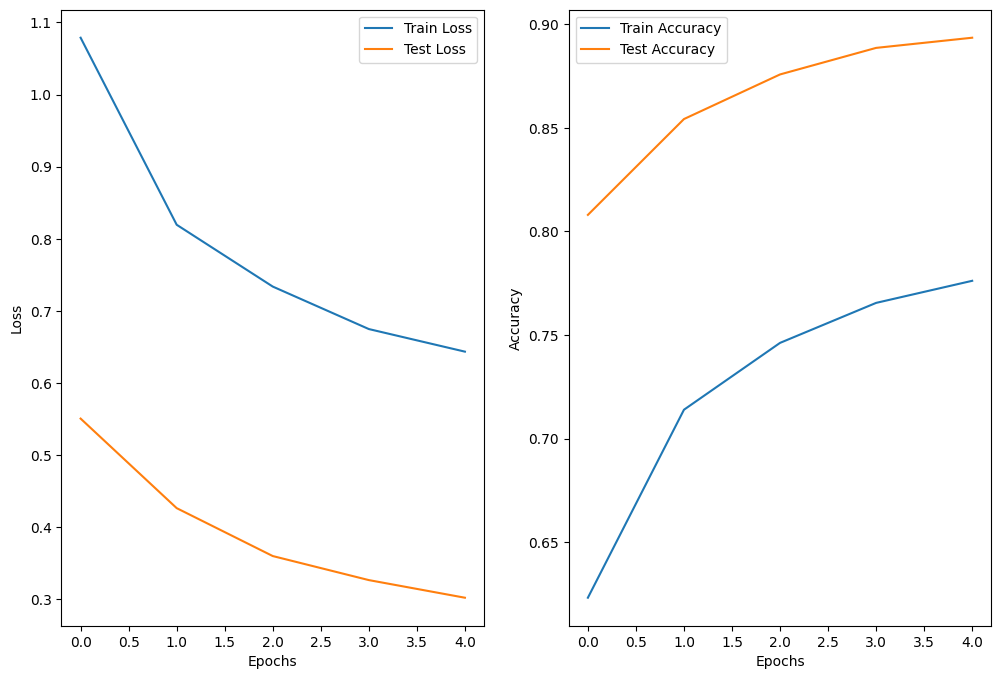

In [ ]:
figure = plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(epoch_count, total_training_loss, label='Train Loss')
plt.plot(epoch_count, total_testing_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_count, total_train_acc, label='Train Accuracy')
plt.plot(epoch_count, total_test_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()